In [6]:
import numpy as np
import sys
sys.path.append("F:\MachineLearning\MachineLearn\ML_Notes-master\ML_Notes-master")
from ml_models import utils
from ml_models.tree import CARTClassifier
import copy
import numpy as np
%matplotlib inline

In [7]:
class AdaBoostClassifier(object):
    def __init__(self, base_estimator = None, n_estimators=10, learning_rate=1.0):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

        if self.base_estimator is None:
            self.base_estimator = CARTClassifier(max_depth=2)
        #同质分类器
        if type(base_estimator)!=list:
            estimator = base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        else:
            self.n_estimators = len(self.base_estimator)

        self.estimator_weights = []
    
    def fit(self,x,y):
        n_sample = x.shape[0]
        sample_weights = np.asarray([1.0] * n_sample)
        for index in range(0, self.n_estimators):
            #cart树
            self.base_estimator[index].fit(x, y, sample_weight=sample_weights)
            #是否正确分类了
            indicates = (self.base_estimator[index].predict(x)== y).astype(int)
            #计算误分类率
            error_rate = np.sum([sample_weights[j]*(1.0 - indicates[j]) for j in range(0, n_sample)]) / n_sample
            
            #计算权重系数
            alpha_rate = 1.0/2.0*np.log((1-error_rate)/error_rate + 1e-7)
            alpha_rate = min(10, alpha_rate)
            #加入到最后的系数
            self.estimator_weights.append(alpha_rate)
            
            #更新样本权重
            for j in range(0, n_sample):
                sample_weights[j] = sample_weights[j]*np.exp((-1)*alpha_rate*np.power(-1.0, 1 - indicates[j]))
            sample_weights = sample_weights / np.sum(sample_weights) * n_sample
            
        # 更新estimator权重
        for i in range(0, self.n_estimators):
            self.estimator_weights[i] *= np.power(self.learning_rate,i)
    
    def predict_proba(self, x):
        result = np.sum([self.base_estimator[j].predict_proba(x) * self.estimator_weights[j] for j in range(0, self.n_estimators)],
                       axis=0)
        return result / result.sum(axis=1,keepdims=True)
    
    def predict(self,x):
        return np.argmax(self.predict_proba(x), axis=1)

In [8]:
#伪造数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2,n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

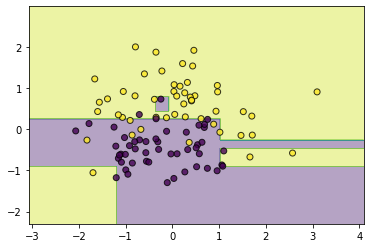

In [11]:
classifier = AdaBoostClassifier(base_estimator=CARTClassifier(max_depth=2),n_estimators=10)
classifier.fit(data,target)
utils.plot_decision_function(data,target,classifier)